# Inference in a matrix model with HMC

Consider the model
\begin{align}
A &\sim \mathcal{N} (A_0, W\otimes W)\\
B &\sim \mathcal{N} (B_0, V\otimes V)\\
Y \mid A, B &\sim A \sim \mathcal{N} (Y; AB, \Sigma)
\end{align}

Goal: Infer A, B

In [1]:
import numpy as np
import scipy.linalg as slinalg
from matplotlib import pyplot as plt
import time

from hamiltonian_mc import HamiltonianMonteCarlo, GPGradientHMC

# turn off numpy multithreading
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import sys

sys.path.append('../../src')
from inference import DerivativeGaussianProcess
from kernels import RBF, ExponentialKernel, LinearKernel

In [2]:
class MatrixModel:
    """
    Matrix model
    """

    def __init__(self, Y, A0, B0, W, V, Sigma):
        """
        Y: (D^2, N)
        A0, B0: (D, D)
        W, V: (D, D)
        Sigma (D^2, D^2)
        """
        self.Y = Y
        self.A0 = A0
        self.B0 = B0
        self.dim = self.A0.shape[0]
        
        if self.dim > 1:
            self.L_WkronW = slinalg.cho_factor(np.kron(W, W))
            self.L_VkronV = slinalg.cho_factor(np.kron(V, V))
            self.LS = slinalg.cho_factor(Sigma)
        else:
            self.L_WkronW = np.sqrt((np.kron(W, W)))
            self.L_VkronV = np.sqrt((np.kron(V, V)))
            self.LS = np.sqrt(Sigma)
        

    def _loglikelihood(self, x):
        """
        log p (Y | A, B), where A, B are summarized in x
        :param x: parameter vector (2 D^2, M)
        """
        d = self.Y[..., None] - self._AB(x)[:, None, :]
        dSd = (d * cho_solve(self.LS, d, self.dim)).sum(axis=(0,1))
        return - 0.5 * dSd   # shape (M,)
    
    def _grad_loglikelihood(self, x):
        """
        Gradient of Log logistic regression likelihood wrt x.
        x: (2 D^2, M)
        """
        IkronA = np.kron(np.eye(self.dim), x[:self.dim**2, :].reshape(self.dim, self.dim, order='f'))
        BTkronI = np.kron(x[self.dim**2:, :].reshape(self.dim, self.dim, order='f').T, np.eye(self.dim))
        d = self.Y[..., None] - self._AB(x)[:, None, :]
        Sd = (cho_solve(self.LS, d, self.dim)).sum(axis=1)
        
        gradA = BTkronI.T @ Sd #assuming S is symmetric
        gradB = IkronA.T @ Sd
        return np.vstack([gradA.reshape(self.dim**2,-1, order='f'), gradB.reshape(self.dim**2,-1, order='f')])

    def _logprior(self, x):
        """
        Log Gaussian prior density of x
        x: (2 D^2, M)
        """
        a = x[:self.dim**2, :] - self.A0.reshape(-1,1, order='f')
        b = x[self.dim**2:, :] - self.B0.reshape(-1,1, order='f')
        aWa = (a * cho_solve(self.L_WkronW, a, self.dim)).sum(axis=0)
        bVb = (b * cho_solve(self.L_VkronV, b, self.dim)).sum(axis=0)
        return -0.5*(aWa + bVb)
    
    def _grad_logprior(self, x):
        """
        Gradient of Log independent Gaussian prior density wrt x.
        """
        a = x[:self.dim**2, :] - self.A0.reshape(-1,1, order='f')
        b = x[self.dim**2:, :] - self.B0.reshape(-1,1, order='f')
        Wa = cho_solve(self.L_WkronW, a, self.dim)
        Vb = cho_solve(self.L_VkronV, b, self.dim)
        return - np.vstack([Wa, Vb])

    def energy(self, x):
        return -(self._loglikelihood(x) + self._logprior(x))

    def gradient(self, x):
        return - (self._grad_loglikelihood(x) + self._grad_logprior(x))
    
    def _AB(self, x):
        A = x[:self.dim**2, :].reshape(self.dim, self.dim, -1, order='f')
        B = x[self.dim**2:, :].reshape(self.dim, self.dim, -1, order='f')
        return np.einsum('ijk,jlk->ilk', A, B).reshape(self.dim**2, -1, order='f')
        

def cho_solve(L, b, dim):
    if dim == 1.:
        return b / L**2
    return slinalg.cho_solve(L, b)

In [3]:
def generate_matrix_data(n, A, B, Sigma):
    """
    Generate data from a matrix-variate Gaussian with mean AB and cov Sigma
    """
    AB = A@B
    L = slinalg.cholesky(Sigma, lower=True)
    Y = AB.reshape(AB.size, 1) + (L @ np.random.randn(AB.size, n))
    return Y

def draw_gaussian_matrix(A0, W):
    L_WkW = slinalg.cholesky(np.kron(W, W), lower=True)
    return A0 + (L_WkW @ np.random.randn(A0.size)).reshape(A0.shape)

## Make contour plot for d=1

In [63]:
dim = 1
D = 2*dim**2   # effective dimensionality of problem
ndat = 1000

A0 = np.zeros((dim,dim))
B0 = np.zeros((dim,dim))
W = np.eye(dim)/D
V = np.eye(dim)/D

np.random.seed(0)
A = draw_gaussian_matrix(A0, W)
B = draw_gaussian_matrix(B0, V)

x_true = np.vstack([A.reshape(-1,1, order='f'), B.reshape(-1,1, order='f')])

Sigma = np.eye(dim**2) * D
Y = generate_matrix_data(ndat, A, B, Sigma)

In [64]:
# set up model
mamo1 = MatrixModel(Y, A0, B0, W, V, Sigma)

In [65]:
# generate HMC samples
T = 100
h = 5.e-2

N_burn = dim
N_sample = 100
mass = 1.

np.random.seed(10)
x0 = np.vstack([draw_gaussian_matrix(A0, W).reshape(-1,1, order='f'), draw_gaussian_matrix(B0, V).reshape(-1,1, order='f')])

hmc = HamiltonianMonteCarlo(mamo1.energy, mamo1.gradient, T, h, mass=mass, N_burn=N_burn)
X_hmc = hmc.sample(N_sample, x0)

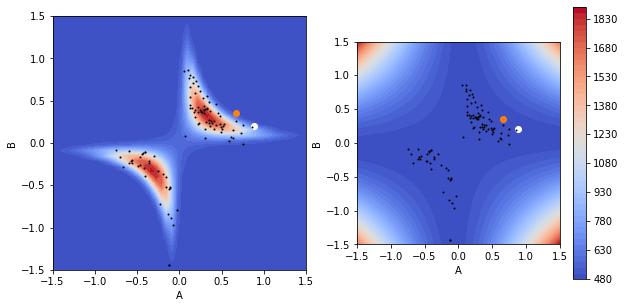

In [66]:
N_plot = 50

x_plot = np.linspace(-1.5,1.5,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=0)).reshape(2, -1)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(X1, X2, np.exp(-mamo1.energy(X)).reshape(N_plot, N_plot, order='f'), cmap='coolwarm', levels=50)
cpl = ax[1].contourf(X1, X2, mamo1.energy(X).reshape(N_plot, N_plot, order='f'), cmap='coolwarm', levels=50)
plt.colorbar(cpl, ax=ax[1])
for i in range(2):
    ax[i].scatter(x0[0], x0[1], c='C1')
    ax[i].scatter(x_true[0], x_true[1], c='w')
    ax[i].scatter(X_hmc[:,0], X_hmc[:,1], c='k', s=1.)
    ax[i].set_xlabel('A')
    ax[i].set_ylabel('B')
    ax[i].set_aspect('equal')
   
# plt.savefig('test.png', format='png')
plt.show()


## Generate high-dim. data

(16, 1000)

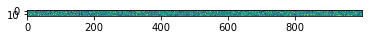

In [219]:
dim = 4
D = 2*dim**2   # effective dimensionality of problem
ndat = 1000

A0 = np.zeros((dim,dim))
B0 = np.zeros((dim,dim))
W = np.eye(dim)/D
V = np.eye(dim)/D

np.random.seed(0)
A = draw_gaussian_matrix(A0, W)
B = draw_gaussian_matrix(B0, V)

x_true = np.vstack([A.reshape(-1,1, order='f'), B.reshape(-1,1, order='f')])

plt.imshow(B)

Sigma = np.eye(dim**2) * D

Y = generate_matrix_data(ndat, A, B, Sigma)

plt.imshow(Y)
Y.shape

## Set up model

In [220]:
mamo = MatrixModel(Y, A0, B0, W, V, Sigma)

Note: HMC will deal with a parameter vector $\theta = [\vec{A}, \vec{B}]$, and data $Y$ is vectorized.

## Hamiltonian Monte Carlo

In [221]:
seeds = np.arange(10) + 42

# sqrt4_d = int(np.ceil(dim**0.25))


# T = 50
T = 100
h = 5.e-2

N_burn = dim
N_sample = 100

mass = 1.#D
# mass= 1./logreg.scale()

In [222]:
# STANDARD HMC SAMPLING
np.random.seed(10)
x0 = np.vstack([draw_gaussian_matrix(A0, W).reshape(-1,1, order='f'), draw_gaussian_matrix(B0, V).reshape(-1,1, order='f')])

hmc = HamiltonianMonteCarlo(mamo.energy, mamo.gradient, T, h, mass=mass, N_burn=N_burn)

t_hmc = time.process_time()
X_hmc = hmc.sample(N_sample, x0)
t_hmc = time.process_time() - t_hmc

In [234]:
# GPG HMC SAMPLING
np.random.seed(seeds[0])
x0 = np.vstack([draw_gaussian_matrix(A0, W).reshape(-1,1, order='f'), draw_gaussian_matrix(B0, V).reshape(-1,1, order='f')])

kern = RBF(D, 1000.)
gp = DerivativeGaussianProcess(kern)

gpg_hmc = GPGradientHMC(mamo.energy, mamo.gradient, gp_model=gp, T=T, h=h, mass=mass, N_train=10, N_burn=N_burn)

t_gph = time.process_time()
X_gph = gpg_hmc.sample(N_sample, x0)
t_gph = time.process_time() - t_gph

In [235]:
gpg_hmc.gp_trainer.N_dat

1

In [225]:
print(t_hmc, t_gph)

12.471619591000007 12.383037158999969


In [226]:
hmc.diagnostics.acceptance_rate, gpg_hmc.diagnostics.acceptance_rate, gpg_hmc.gp_trainer.diagnostics.acceptance_rate

(0.01999999999999999, 0.0, 0.0)

In [36]:
# dists = np.triu(np.sqrt(((X_hmc[:, None, :] - X_hmc[None, :, :])**2).sum(axis=-1)))[np.triu_indices(N_sample, k=1)]
# # dists = np.triu(np.sqrt((((gp.data['dX'].T)[None, :, :] - (gp.data['dX'].T)[:, None, :])**2).sum(axis=-1)))[np.triu_indices(5, k=1)]
# plt.hist(dists)
# plt.yscale('log')
# plt.axvline(np.sqrt(dim), c='C3')
# dists.shape

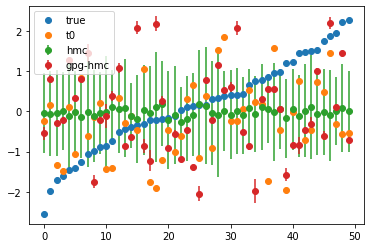

In [37]:
idx = np.argsort(x_true[:,0])
plt.plot(x_true[idx], 'o' , label='true')
plt.plot(x0[idx], 'o', label='t0')
plt.errorbar(np.arange(0, max(idx)+1), X_hmc.mean(axis=0)[idx], X_hmc.std(axis=0)[idx], marker='o', ls='', label='hmc')
plt.errorbar(np.arange(0, max(idx)+1), X_gph.mean(axis=0)[idx], X_gph.std(axis=0)[idx], marker='o', ls='', label='gpg-hmc')

plt.legend()

### Test matrix gradient

In [91]:
tt = np.random.randn(2*dim**2, 1)

def num_grad(t, fun):
    dt = 1.e-5
    grad = np.zeros_like(tt)
    for i in range(tt.shape[0]):
        one_hot = np.zeros_like(tt)
        one_hot[i,0] = 1.
        grad[i,0] = (fun(t + one_hot * dt) - fun(t - one_hot * dt))/(2*dt)
    return grad

np.testing.assert_array_almost_equal(num_grad(tt, mamo._loglikelihood), mamo._grad_loglikelihood(tt))
np.testing.assert_array_almost_equal(num_grad(tt, mamo._logprior), mamo._grad_logprior(tt))
np.testing.assert_array_almost_equal(num_grad(tt, mamo.energy), mamo.gradient(tt))